In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
from sklearn.decomposition import NMF
from scipy.signal import find_peaks

In [3]:
# loading all ITPC spectrum from all shafts in both left and right aac during pure tone presentation
all_shafts = np.load("/home/jeremy/Desktop/all_shafts_puretone.npy")

#individual bundary for number of shafts
limits = np.load("/home/jeremy/Desktop/all_shafts_puretone_individual_limits.npy")

In [4]:
# using nmf to find components 

X = all_shafts.T.copy()
model = NMF(n_components=4, init='nndsvd', solver= 'cd',random_state=42,max_iter=1000, alpha=0.2)
W = model.fit_transform(X)
H = model.components_
scores = W.copy()

In [5]:
# group together delta/beta components and theta/gamma components 
idl1 = 2; idl2 = 3; idr1 = 0; idr2 =1 # component #

nleft = 12
xl = []; yl = []
xr = []; yr = []

x = []
for num,j in enumerate(limits):
    if num == 0: # patients left first
        xl.append(np.mean(np.concatenate(scores[0:j,[idl1,idl2]],0) ,0))
        yl.append(np.mean(np.concatenate(scores[0:j, [idr1,idr2]],0) ,0))
    elif num < nleft:
        xl.append(np.mean(np.concatenate(scores[limits[num-1]+1:j , [idl1,idl2]],0) ,0))
        yl.append(np.mean(np.concatenate(scores[limits[num-1]+1:j, [idr1, idr2]],0),0))
    else:
        xr.append(np.mean(np.concatenate(scores[limits[num-1]+1:j, [idl1, idl2]],0),0))
        yr.append(np.mean(np.concatenate(scores[limits[num-1]+1:j, [idr1, idr2]],0) ,0))

In [10]:
# retrieving weights by hemisphere and by component
left_score = scores[0:limits[12],:]
right_score = scores[limits[12]::,:]

freqs_d= [[],[],[],[]]
for i in range(4):
    freqs_d[i]=np.mean(right_score[:,i],0)
freqs_g= [[],[],[],[]]
for i in range(4):
    freqs_g[i]=np.mean(left_score[:,i],0)
    
freqs_gtg = np.sum((left_score[:,2],left_score[:,3]),0)/2
freqs_dtg = np.sum((right_score[:,2],right_score[:,3]),0)/2
freqs_gdb = np.sum((left_score[:,0],left_score[:,1]),0)/2
freqs_ddb = np.sum((right_score[:,0],right_score[:,1]),0)/2    

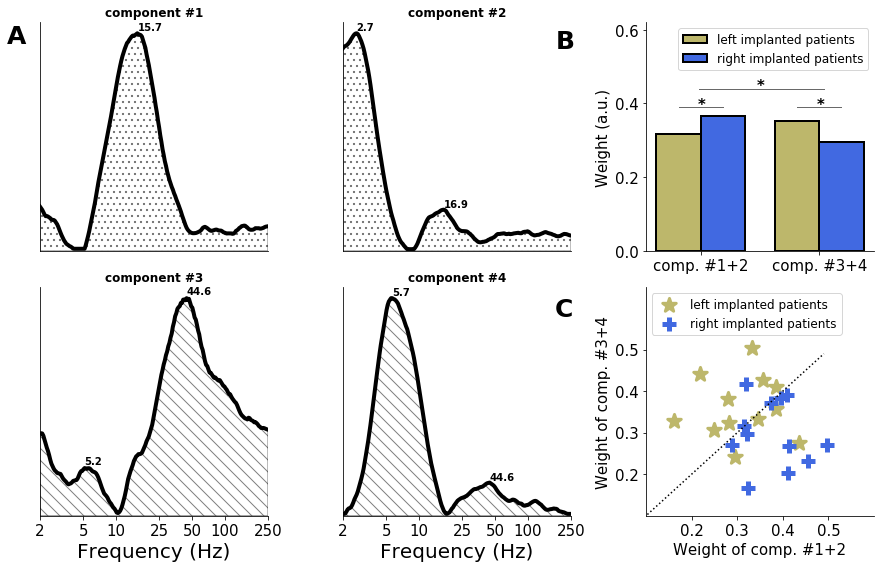

In [11]:
# plotting components and weights  

freqs= np.logspace(*np.log10([2, 250]), num=200)


figs5, axs = plt.subplots(2,3,figsize=(12,8))
idx = [0,1,0,2,3]

for i, (num, ax) in enumerate(zip(range(6),axs.ravel())):
    if num in [0,1,3,4]:
        ax.plot(freqs,H[idx[num],:], linewidth = 4,color = 'k')
        ax.set_xscale('log')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.xaxis.set_minor_formatter(ticker.NullFormatter())
        ax.xaxis.set_minor_locator(ticker.NullLocator())
        n_values = 7
        tick_vals = np.array([2,5,10,25,50,100,250])
        tick_vals = tick_vals.astype(int)
        ax.set_xticks(tick_vals)
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())
        ax.yaxis.set_minor_locator(ticker.NullLocator())
        if idx[num] in [2,3]:
            ax.set_xlabel('Frequency (Hz)', fontsize = 20)
        if idx[num] == 0:    
            ax.text(1,.95, "A", fontsize = 25, weight = 'bold')
        ax.set_title("component #"+str(idx[num]+ 1), weight = 'bold')
        if idx[num]in [2,3]:
            ax.fill_between(freqs,H[idx[num],:],-0.01, hatch ='\\\\' , facecolor = 'none',alpha=0.5)
        if idx[num] in [0,1]:
            ax.fill_between(freqs,H[idx[num],:],-0.01, hatch ='..' , facecolor = 'none',alpha=0.5)
            
        ax.set_xlim(0,250)
        ax.set_ylim(-0.01)
        ax.set_yticks([])
        if idx[num] in [0,1] :
            ax.axes.get_xaxis().set_visible(False)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
        spectra = H[idx[num],:].copy()
        b=find_peaks(spectra,prominence=0.035, distance= 20) 
        freq_ind=b[0]
        for j in freq_ind:
            ax.text(freqs[j],np.take(spectra,j)+0.015, str(np.round(freqs[j],1)), weight ='bold')
    elif num == 2 :
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
        ax.bar([0, 0.8], [freqs_gdb.mean(),freqs_gtg.mean()], width=0.3, label = 'left implanted patients', color=('darkkhaki','darkkhaki' ), align='center', edgecolor = 'k', linewidth = 2)
        ax.bar([0.3, 1.1], [freqs_ddb.mean(),freqs_dtg.mean()], width=0.3, label = 'right implanted patients', color=('royalblue', 'royalblue'), align='center', edgecolor = 'k', linewidth = 2)
        ax.set_xticks([.15,.95])
        ax.set_xticklabels(["comp. #1+2","comp. #3+4"],fontsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylabel('Weight (a.u.)',fontsize =15)
        ax.legend(fontsize = 12)
        ax.set_ylim(0,.62)
        ax.text(-0.83,.55, "B", fontsize = 25, weight = 'bold')
        ax.set_yticks(np.array([0,0.2,.4,.6]))
        ax.plot([0.0, 0.3], [.39, .39], 'dimgrey', lw=1)
        ax.text(0.13, .385, '*', color='k', weight='bold', fontsize=15)
        ax.plot([.8, 1.1], [.39, .39], 'dimgrey', lw=1)
        ax.text(.93, .385, '*', color='k', weight='bold', fontsize=15)
        ax.plot([.135, .98], [.44, .44], 'dimgrey', lw=1)
        ax.text(.53, .435, '*', color='k', weight='bold', fontsize=15)


    else :
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
        ax.scatter(yl,xl, color = 'darkkhaki',label = 'left implanted patients', linewidth='3',marker = '*', s = 200)
        ax.scatter(yr,xr, color = 'royalblue',label = 'right implanted patients', linewidth='5', marker = '+', s = 200) 
        ax.plot(np.arange(0,0.5,0.01),np.arange(0,0.5,0.01), color = 'k', linestyle = ':')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(0.1,0.6)
        ax.set_ylim(0.1,0.65)
        ax.set_xlabel( 'Weight of comp. #1+2' , fontsize = 15)
        ax.set_ylabel('Weight of comp. #3+4', fontsize = 15)
        ax.set_xticks([0.2, 0.3, 0.4,0.5])
        ax.set_yticks([0.2, 0.3, 0.4, 0.5])
        ax.legend(loc=2,fontsize = 12)
        ax.text(-0.1,0.58, "C", fontsize = 25, weight = 'bold')

plt.tight_layout();